<a href="https://colab.research.google.com/github/PeanutButtermitKase/MolecularModelingTools/blob/main/RL_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 10%|█         | 521/5000 [00:19<01:09, 64.18it/s]

Episode 500: Avg Reward (last 500): -200.00, Epsilon: 0.606


 20%|██        | 1006/5000 [00:27<01:07, 59.32it/s]

Episode 1000: Avg Reward (last 500): -200.00, Epsilon: 0.368


 30%|███       | 1509/5000 [00:35<01:03, 55.18it/s]

Episode 1500: Avg Reward (last 500): -198.64, Epsilon: 0.223


 40%|████      | 2016/5000 [00:44<00:49, 59.86it/s]

Episode 2000: Avg Reward (last 500): -195.59, Epsilon: 0.135


 50%|█████     | 2506/5000 [00:52<00:44, 56.64it/s]

Episode 2500: Avg Reward (last 500): -190.91, Epsilon: 0.082


 60%|██████    | 3008/5000 [00:59<00:31, 63.66it/s]

Episode 3000: Avg Reward (last 500): -183.84, Epsilon: 0.050


 70%|███████   | 3510/5000 [01:07<00:19, 77.32it/s]

Episode 3500: Avg Reward (last 500): -181.44, Epsilon: 0.050


 80%|████████  | 4012/5000 [01:14<00:15, 65.63it/s]

Episode 4000: Avg Reward (last 500): -182.42, Epsilon: 0.050


 90%|█████████ | 4510/5000 [01:21<00:07, 64.63it/s]

Episode 4500: Avg Reward (last 500): -173.94, Epsilon: 0.050


100%|██████████| 5000/5000 [01:28<00:00, 56.37it/s]


Episode 5000: Avg Reward (last 500): -175.29, Epsilon: 0.050


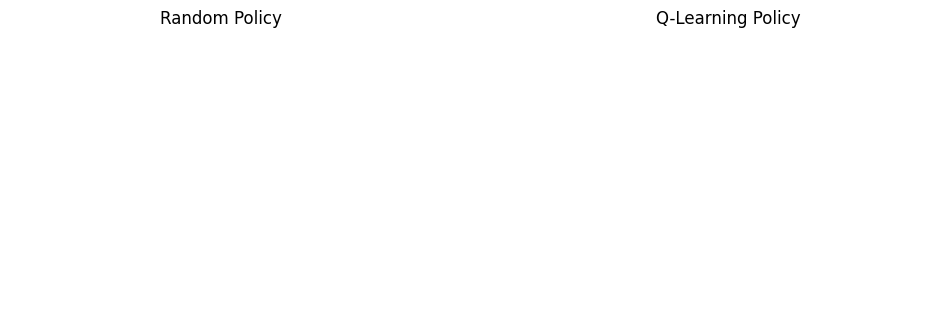

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import display
from tqdm import trange

rc('animation', html='jshtml')

# Environment setup
env = gym.make("MountainCar-v0", render_mode="rgb_array")
np.random.seed(42)
env.reset(seed=42)

# Discretization setup
bins = [20, 20]  # number of bins for position and velocity

# Discretize continuous state
def discretize(obs, bins):
    upper_bounds = np.array([0.6, 0.07])
    lower_bounds = np.array([-1.2, -0.07])
    ratios = (obs - lower_bounds) / (upper_bounds - lower_bounds)
    discrete_obs = np.round((np.array(bins) - 1) * ratios).astype(int)
    discrete_obs = np.clip(discrete_obs, 0, np.array(bins) - 1)
    return tuple(discrete_obs)

# Q-learning training function
def train_q_learning(env, bins, num_episodes=5000, learning_rate=0.1,
                     discount_factor=0.99, epsilon=1.0, epsilon_decay=0.999,
                     epsilon_min=0.05):

    q_table = np.zeros(bins + [env.action_space.n])
    rewards_per_episode = []

    for episode in trange(num_episodes):
        obs, _ = env.reset()
        discrete_state = discretize(obs, bins)
        done = False
        total_reward = 0

        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[discrete_state])

            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_discrete_state = discretize(next_obs, bins)

            # Q-learning update
            best_future_q = np.max(q_table[next_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            q_table[discrete_state + (action,)] += learning_rate * (reward + discount_factor * best_future_q - current_q)

            discrete_state = next_discrete_state
            total_reward += reward
            done = terminated or truncated

        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        rewards_per_episode.append(total_reward)

        if (episode + 1) % 500 == 0:
            avg_r = np.mean(rewards_per_episode[-500:])
            print(f"Episode {episode + 1}: Avg Reward (last 500): {avg_r:.2f}, Epsilon: {epsilon:.3f}")

    return q_table, rewards_per_episode

# Train the agent
q_table, rewards = train_q_learning(env, bins)

# Policies
def random_policy(_):
    return env.action_space.sample()

def trained_policy(discrete_state):
    return np.argmax(q_table[discrete_state])

# Capture frames from policy
def capture_episode_frames(policy_fn):
    frames = []
    obs, _ = env.reset()
    discrete_state = discretize(obs, bins)
    done = False

    while not done:
        action = policy_fn(discrete_state)
        next_obs, reward, terminated, truncated, _ = env.step(action)

        frame = env.render()
        frames.append(frame)

        discrete_state = discretize(next_obs, bins)
        done = terminated or truncated

    return frames

# Record and compare
frames_random = capture_episode_frames(random_policy)
frames_trained = capture_episode_frames(trained_policy)

# Plot side-by-side animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("Random Policy")
ax2.set_title("Q-Learning Policy")
ax1.axis('off')
ax2.axis('off')

ims = []
min_len = min(len(frames_random), len(frames_trained))
for i in range(min_len):
    im1 = ax1.imshow(frames_random[i], animated=True)
    im2 = ax2.imshow(frames_trained[i], animated=True)
    ims.append([im1, im2])

ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
display(ani)
